# School contact graph

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.sparse.linalg import svds
from scipy import linalg
import pyemb as eb

np.random.seed(42)

This tutorial aims to explore the different methods to embed a dynamic network (URLSE, ISE, OMNI and UASE). To do this, we use a [temporal network](http://www.sociopatterns.org/datasets/primary-school-temporal-network-data/) of contacts between the children and teachers in a French school. 

## Load dataset

In [19]:
data = eb.load_lyon()

edge_tuples = data['data']
node_labels = data['labels']

Data loaded successfully


`edge_tuples` contains an array with three columns, the first column is time and the second and third columns are the nodes. The nodes are indicated by integers from 0, with the label of corresponding index giving their class (or `Teachers`).

In [6]:
n = node_labels.shape[0]
T = np.unique(edge_tuples[:,0]).shape[0]

print(f'Number of nodes: {n}')
print(f'Number of time windows: {T}')

Number of nodes: 242
Number of time windows: 71


Transform the edge list into a list of matrices.

In [7]:
As = []
for t in range(T):
    idx = np.where(edge_tuples[:, 0] == str(t))[0]
    A = sparse.coo_matrix((np.ones(len(idx)), ([edge_tuples[i, 1] for i in idx], [edge_tuples[i, 2] for i in idx])), shape=(n,n))
    As.append((A + A.T).sign())

### Embed the dynamic network

In [8]:
# Embed the graph using unfolded regularised Laplacian spectral embedding
d = 10
URLSE_emb = eb.dyn_embed(As, d=d, method="URLSE")

## Quick visualisations

### A quick interactive and animated plot to explore your embedding

Click [here](https://edwarddavis1.github.io/example_pyemb_quick_plot/) to view an example of the interactive output of ```quick_plot()```.

In [9]:
# Quick interactive + animated plot of the embedding
# fig = eb.quick_plot(URLSE_emb, n, T, node_labels)

### Visualise embedding time point snapshots of interest

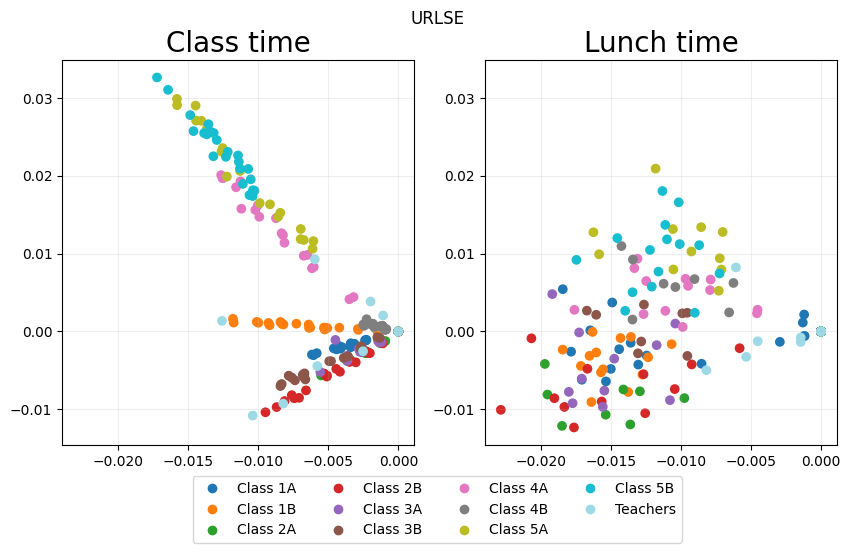

In [10]:
URLSE_emb = eb.dyn_embed(As, d=d, method="URLSE", flat=False)

# Select snapshots to be shown
points_of_interest = [5, 14]
point_labels = ["Class time", "Lunch time"]

# Plot the snapshots
URLSE_fig = eb.snapshot_plot(
    URLSE_emb, 
    node_labels = node_labels, 
    idx_of_interest = points_of_interest, 
    title = point_labels, 
    sharex = True,
    sharey = True,
    tick_labels = True,
    add_legend=True, 
    cmap="tab20"   
)

# Apply any further adjustments to the plot
_ = URLSE_fig.suptitle("URLSE")

### Degree-correct the embedding

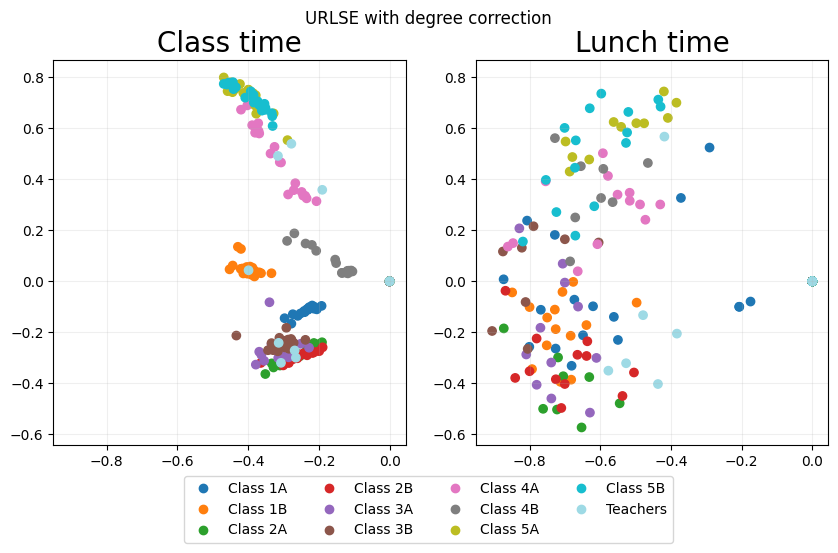

In [12]:
URLSE_emb_dc = eb.degree_correction(URLSE_emb)
URLSE_fig = eb.snapshot_plot(
    URLSE_emb_dc, 
    node_labels = node_labels, 
    idx_of_interest = points_of_interest, 
    title = point_labels, 
    sharex = True,
    sharey = True,
    tick_labels = True,
    add_legend=True, 
    cmap="tab20"   
)

_ = URLSE_fig.suptitle("URLSE with degree correction")

## Compare embedding methods

### Independent spectral embedding

A naive dynamic embedding method where each adjacency matrix is embedded independently using spectral embedding.

As each time point is entirely independent temporal structure is lost, which is illustrated by no two time points looking at all alike.  

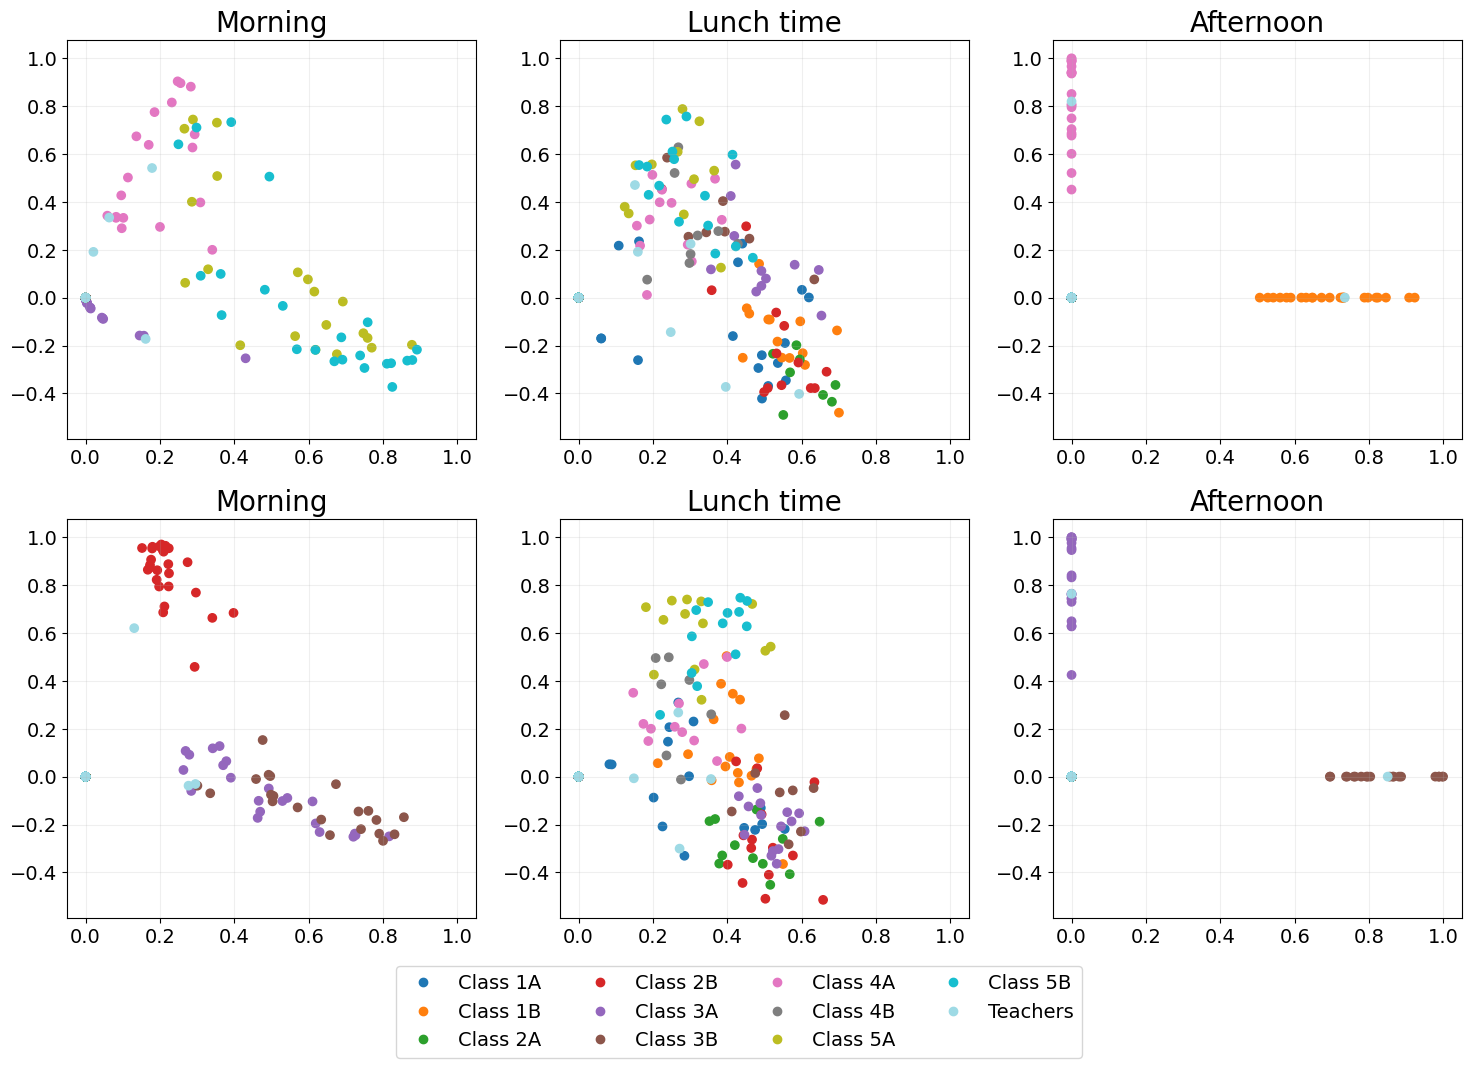

In [13]:
ISE_emb = eb.dyn_embed(As, d, method="ISE")
ISE_emb = eb.degree_correction(ISE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

# Adjust the text size on the plot
plt.rcParams.update({'font.size': 14})

ISE_fig = eb.snapshot_plot(
    ISE_emb, 
    n= n,
    node_labels = node_labels, 
    idx_of_interest = points_of_interest, 
    title = point_labels,
    max_cols=3, 
    sharex = True,
    sharey = True,
    tick_labels = True,
    add_legend=True, 
    cmap="tab20"   
)
plt.tight_layout()

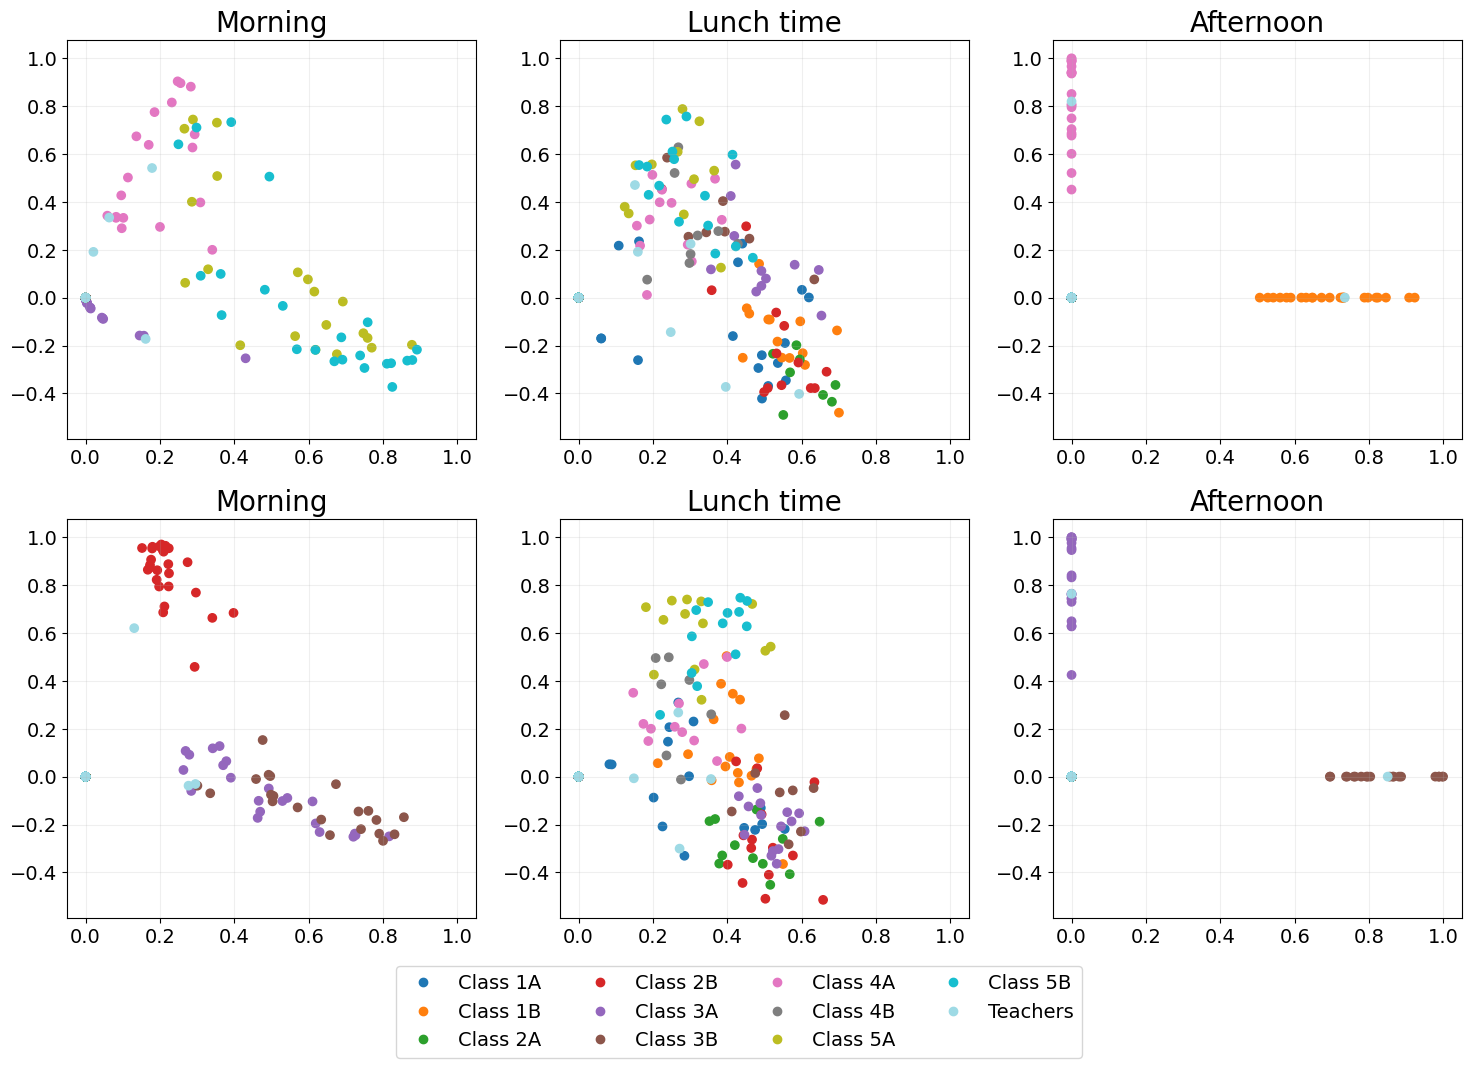

In [14]:
ISE_emb = eb.dyn_embed(As, d, method="ISE")
ISE_emb = eb.degree_correction(ISE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

# Adjust the text size on the plot
plt.rcParams.update({'font.size': 14})

ISE_fig = eb.snapshot_plot(
    ISE_emb, 
    n= n,
    node_labels = node_labels, 
    idx_of_interest = points_of_interest, 
    title = point_labels,
    max_cols=3, 
    sharex = True,
    sharey = True,
    tick_labels = True,
    add_legend=True, 
    cmap="tab20"   
)

plt.tight_layout()

### Omnibus embedding (OMNI)

The OMNI embedding [Levin et al., 2017](https://ieeexplore.ieee.org/abstract/document/8215766?casa_token=A8Vz_qKy3WoAAAAA:TcmJnZtU85qQGJCSTh765-qZnj_carcslkH_ZgRl6U1ffI7YvcDF8wtrGfWhImw-GO8O0OT0-pp5) manages to fix the problem of time points looking completely different, as shown by classes remaining in similar places across all time points. 

However, at lunchtime we expect classes to mix, children play with children from other classes at lunch time. OMNI fails to show this mixing as (e.g. the orange class clearly does not mix).


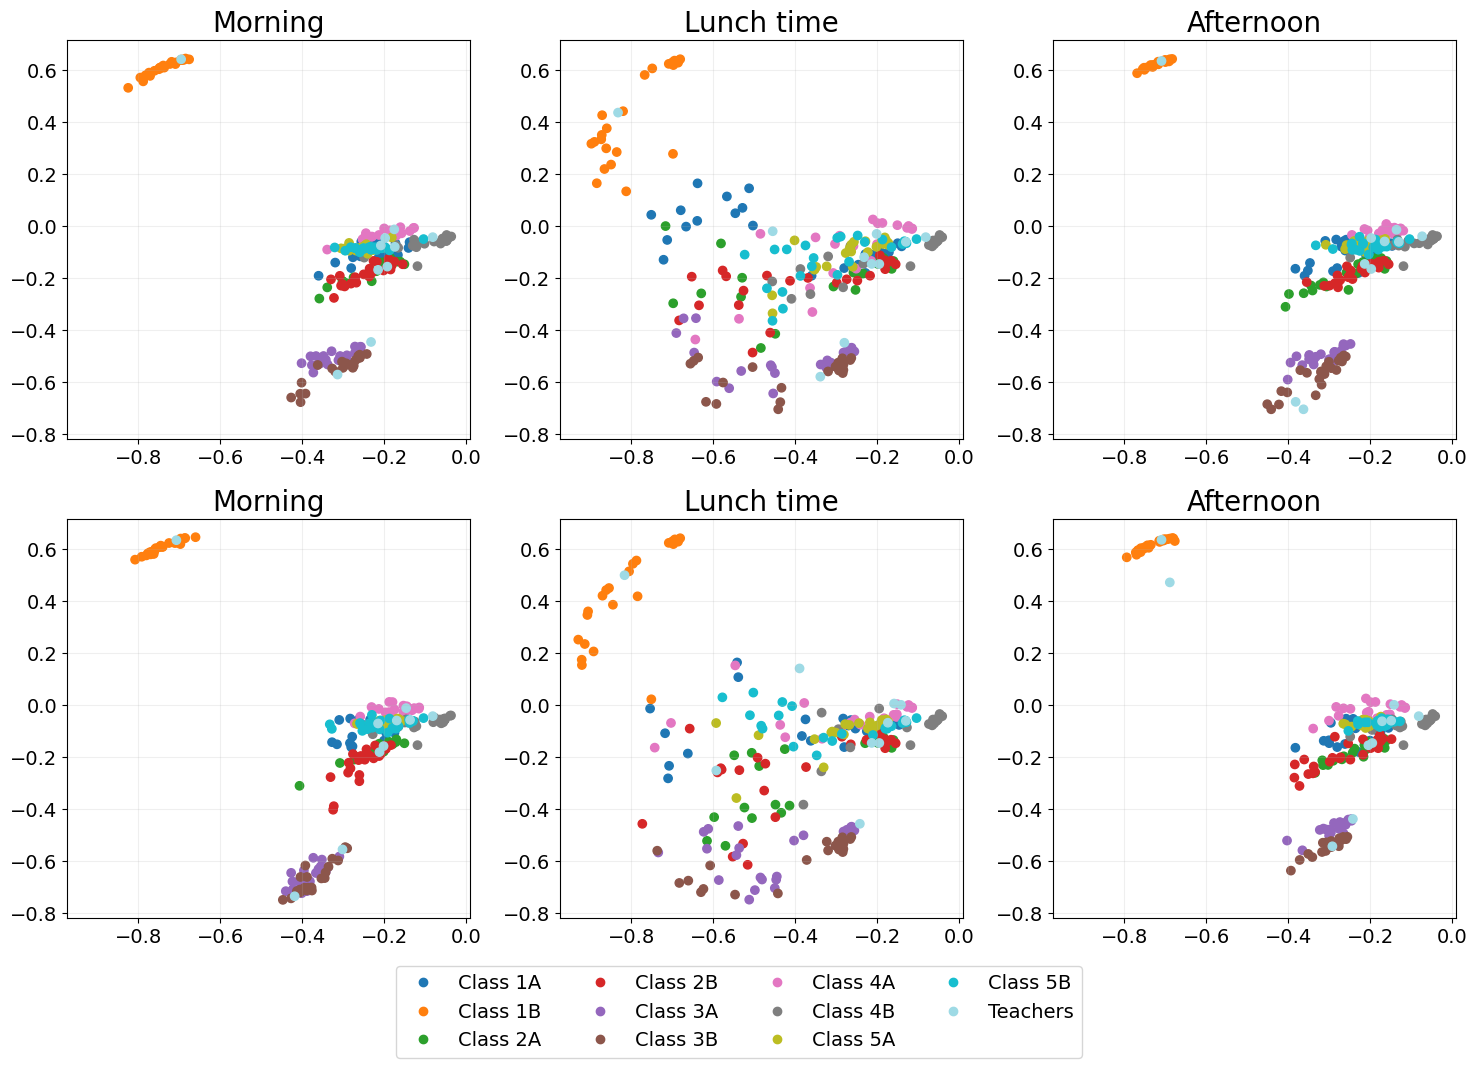

In [15]:
OMNI_emb = eb.dyn_embed(As, d, method="OMNI")
OMNI_emb = eb.degree_correction(OMNI_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

OMNI_fig = eb.snapshot_plot(
    OMNI_emb, 
    n= n,
    node_labels = node_labels, 
    idx_of_interest = points_of_interest, 
    title = point_labels,
    max_cols=3, 
    sharex = True,
    sharey = True,
    tick_labels = True,
    add_legend=True, 
    cmap="tab20"   
)
plt.tight_layout()

### UASE

Unfoled adjacency spectral embedding (UASE) [Jones et al., 2020](https://arxiv.org/abs/2007.10455), [Gallagher et al., 2021](https://proceedings.neurips.cc/paper/2021/hash/5446f217e9504bc593ad9dcf2ec88dda-Abstract.html) was the first of a suite of "unfolded" dynamic embedding methods. Owing to its property of stability, UASE is able to show both the clustering of classes in classtime as well as the total mixing of classes at lunchtime.

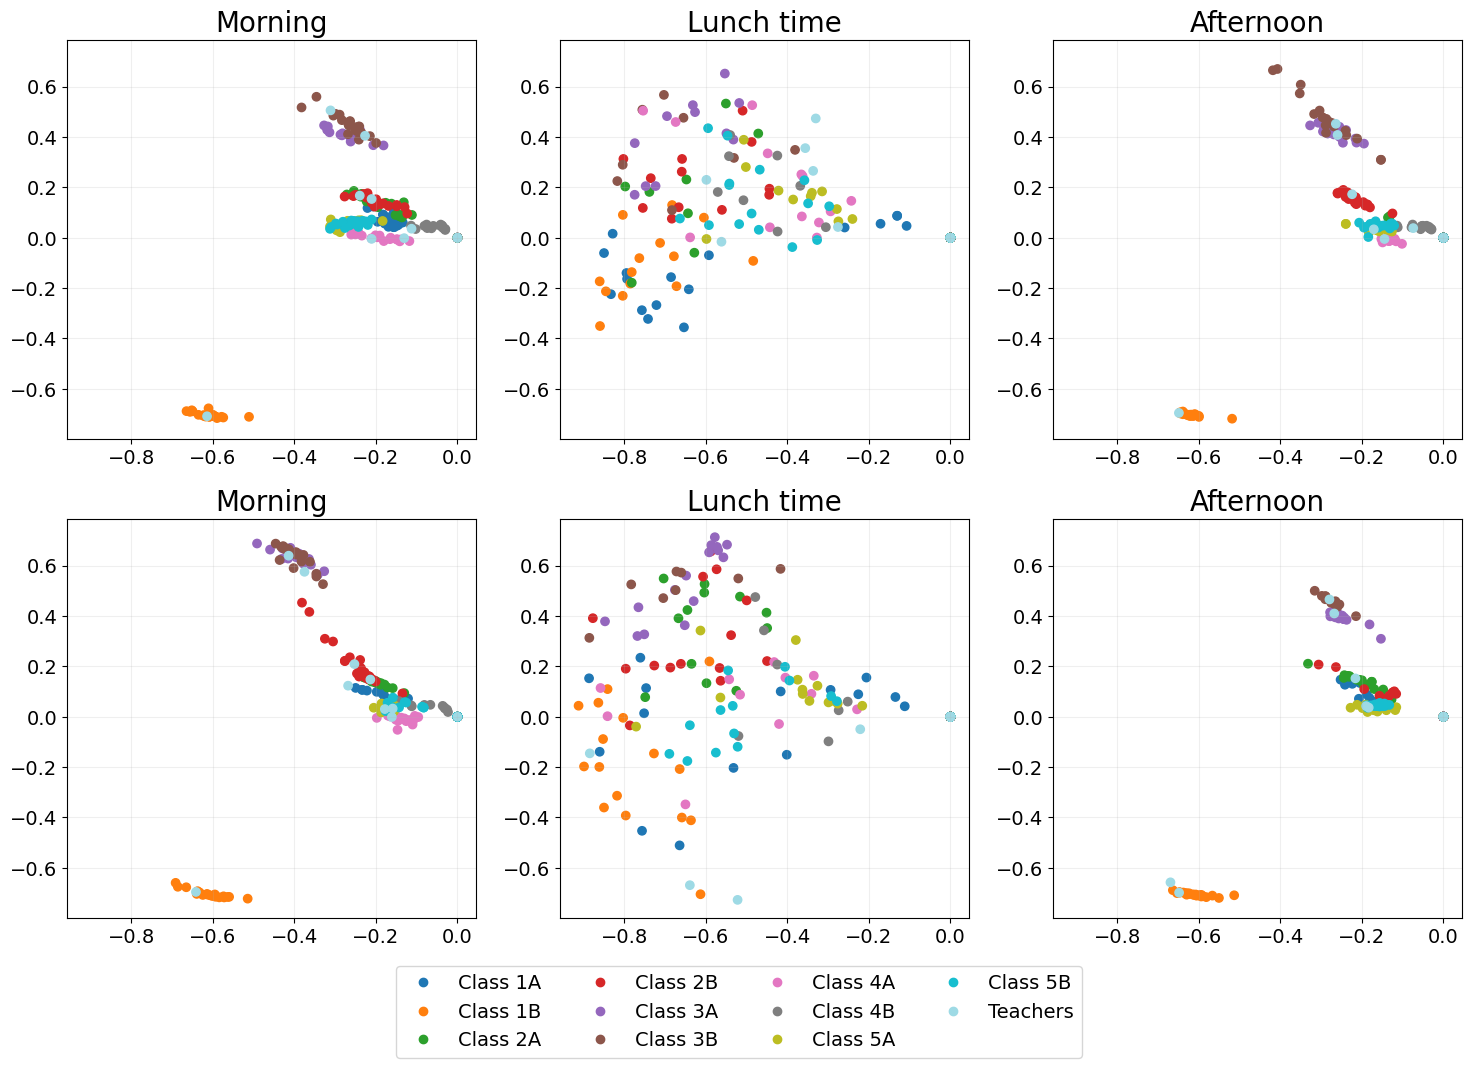

In [16]:
UASE_emb = eb.dyn_embed(As, d, method="UASE")
UASE_emb = eb.degree_correction(UASE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

UASE_fig = eb.snapshot_plot(
    UASE_emb, 
    n= n,
    node_labels = node_labels, 
    idx_of_interest = points_of_interest, 
    title = point_labels,
    max_cols=3, 
    sharex = True,
    sharey = True,
    tick_labels = True,
    add_legend=True, 
    cmap="tab20" 
)
plt.tight_layout()

### URLSE

Unfolded regularised Laplacian spectral embedding (URLSE) is essentially a regularised version of UASE. URLSE is one of many possible unfolded dynamic embedding, all of which feature stability properties [Davis et al., 2023 ](https://arxiv.org/abs/2311.09251). This means that, like UASE, this method is able to display the clustering of classes in classtime and the mixing of classes at lunchtime. 


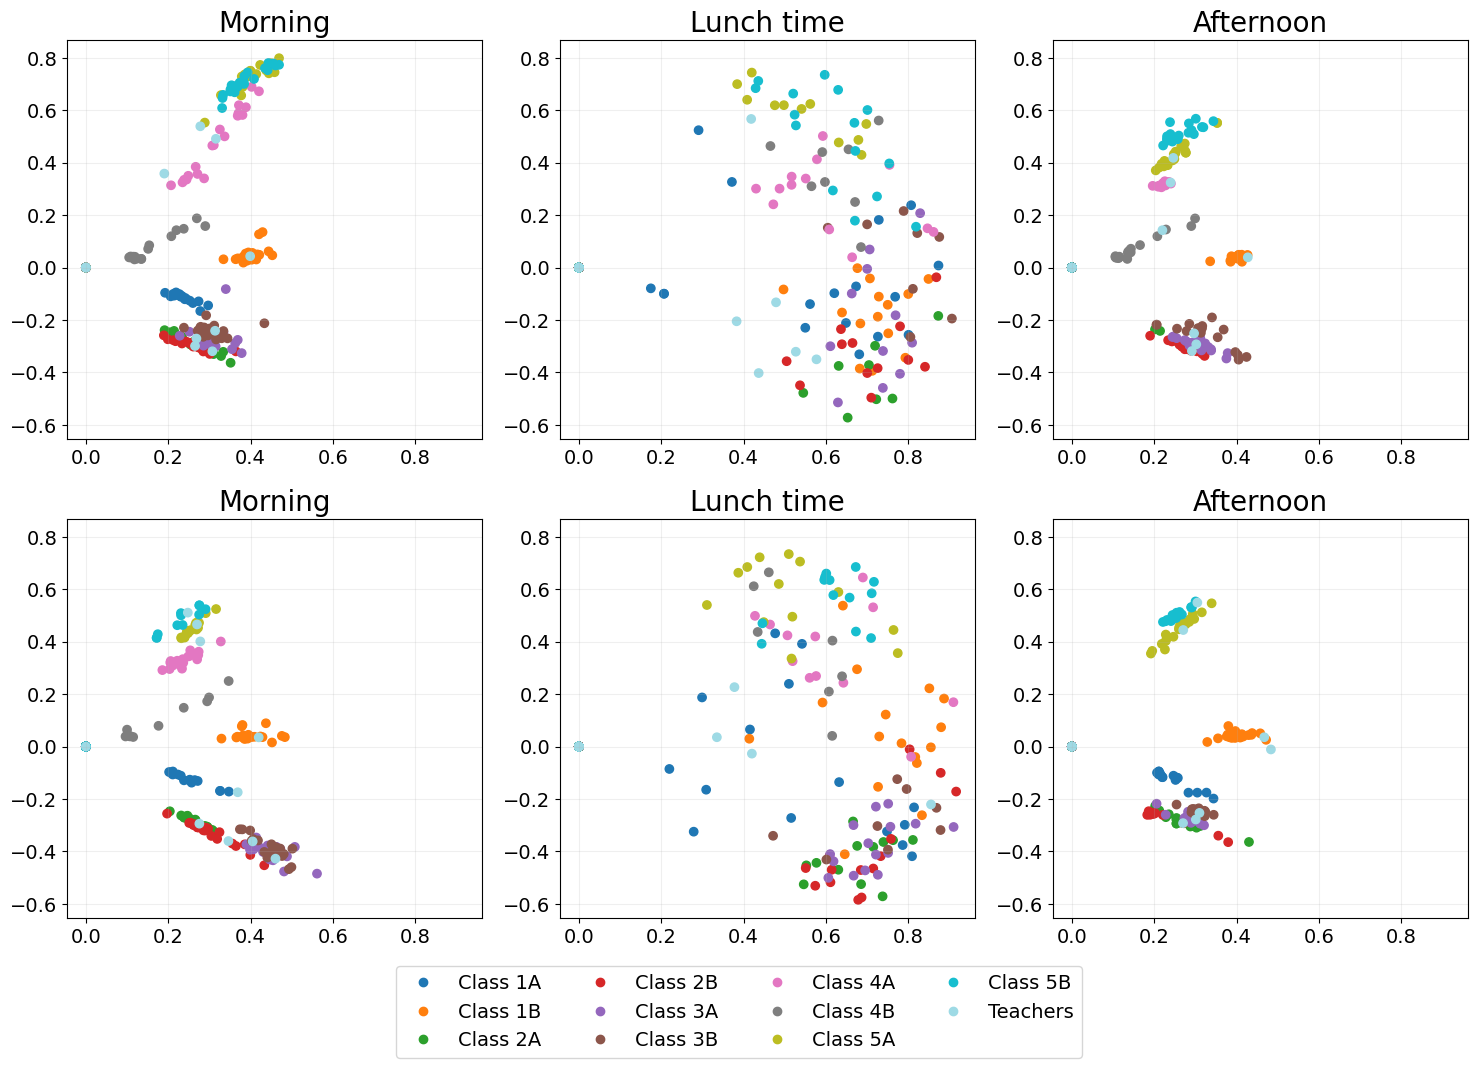

In [17]:
URLSE_emb = eb.dyn_embed(As, d, method="URLSE")
URLSE_emb = eb.degree_correction(URLSE_emb)

points_of_interest = [5, 14, 27, 41, 50, 63]
point_labels = ["Morning", "Lunch time", "Afternoon"] * 2

URLSE_fig = eb.snapshot_plot(
    URLSE_emb, 
    n= n,
    node_labels = node_labels, 
    idx_of_interest = points_of_interest, 
    title = point_labels,
    max_cols=3, 
    sharex = True,
    sharey = True,
    tick_labels = True,
    add_legend=True, 
    cmap="tab20" 
)
plt.tight_layout()

# References

* Levin, K., Athreya, A., Tang, M., Lyzinski, V. and Priebe, C.E., 2017, November. A central limit theorem for an omnibus embedding of multiple random dot product graphs. In 2017 IEEE international conference on data mining workshops (ICDMW) (pp. 964-967). IEEE.

* Jones, A. and Rubin-Delanchy, P., 2020. The multilayer random dot product graph. arXiv preprint arXiv:2007.10455.

* Gallagher, I., Jones, A. and Rubin-Delanchy, P., 2021. Spectral embedding for dynamic networks with stability guarantees. Advances in Neural Information Processing Systems, 34, pp.10158-10170.

* Davis, E., Gallagher, I., Lawson, D.J. and Rubin-Delanchy, P., 2023. A simple and powerful framework for stable dynamic network embedding. arXiv preprint arXiv:2311.09251.